In [ ]:
!pip install datasets
# !pip install transformers[torch] accelerate datasets -U
# !pip install accelerate -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import BigBirdModel, BigBirdTokenizer, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import os

In [ ]:
# Import our dataset
df = pd.read_csv("final_gpt_match_output_clean_res_20240727213717.csv")

label_mapping = {
    'poor fit': 0,
    'good fit': 1,
    'Good Fit': 1,
    'No Fit': 0,
    'Potential Fit': 0
}

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)

min_class_size = df_train['label'].value_counts().min()
df_train = df_train.groupby('label').apply(lambda x: x.sample(min_class_size, random_state=42)).reset_index(drop=True)

In [ ]:
df_train['resume'] = "Resume: " + df_train['resume']
df_train['job_desc'] = "Job Description: " + df_train['job_desc']

df_test['resume'] = "Resume: " + df_test['resume']
df_test['job_desc'] = "Job Description: " + df_test['job_desc']

# Calculate length of each text entry
df_train['combined_text'] = df_train['resume'] + " " + df_train['job_desc']
df_test['combined_text'] = df_test['resume'] + " " + df_test['job_desc']

df_train['length'] = df_train['combined_text'].apply(len)
df_test['length'] = df_test['combined_text'].apply(len)

In [ ]:
df_train['length'].describe()

count      308.000000
mean      8183.068182
std       2667.919652
min       2177.000000
25%       6335.750000
50%       7999.000000
75%       9850.000000
max      18064.000000
Name: length, dtype: float64

In [ ]:
def tokenization(batched_text):
    inputs = tokenizer(batched_text['combined_text'], padding='max_length', truncation=True, max_length=4096)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': batched_text['label']
    }


train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)
num_class = 2

tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-roberta-base", max_length=4096)

train_data = train_data.map(tokenization, batched=True)
test_data = test_data.map(tokenization, batched=True)

train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# def tokenization(batched_text):
#     resume_inputs = tokenizer(batched_text['formatted_resume'], padding='max_length', truncation=True, max_length=4096)
#     job_desc_inputs = tokenizer(batched_text['job_desc'], padding='max_length', truncation=True, max_length=4096)
#     return {
#         'resume_input_ids': resume_inputs['input_ids'],
#         'resume_attention_mask': resume_inputs['attention_mask'],
#         'job_desc_input_ids': job_desc_inputs['input_ids'],
#         'job_desc_attention_mask': job_desc_inputs['attention_mask'],
#         'labels': batched_text['label']
#     }

# train_data = Dataset.from_pandas(df_train)
# test_data = Dataset.from_pandas(df_test)
# num_class = 2

# tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-roberta-base", max_length=4096)


# train_data = train_data.map(tokenization, batched=True, batch_size=len(train_data))
# test_data = test_data.map(tokenization, batched=True, batch_size=len(test_data))

# train_data.set_format('torch', columns=['resume_input_ids', 'resume_attention_mask', 'job_desc_input_ids', 'job_desc_attention_mask', 'labels'])
# test_data.set_format('torch', columns=['resume_input_ids', 'resume_attention_mask', 'job_desc_input_ids', 'job_desc_attention_mask', 'labels'])

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
import torch
from transformers import BigBirdForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BigBirdForSequenceClassification.from_pretrained("google/bigbird-roberta-base", num_labels=2).to(device)
model = model.bert

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Get the last hidden state
            pooled_output = hidden_states[:, 0]  # Use the [CLS] token representation

            embeddings.append(pooled_output.cpu().numpy())
            labels.append(label.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

train_embeddings, train_labels = get_embeddings(model, train_loader)

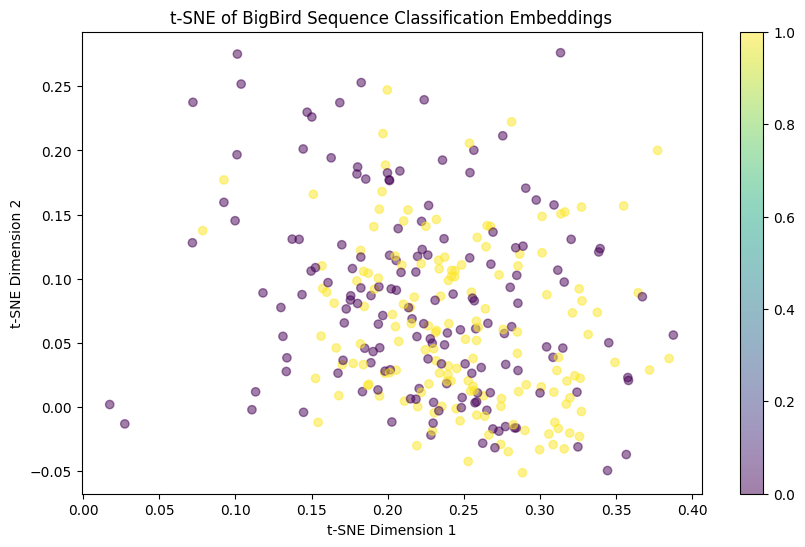

In [ ]:
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

plot_tsne(train_embeddings, train_labels, "t-SNE of BigBird Sequence Classification Embeddings")

In [ ]:
import torch
import torch.nn as nn
from transformers import BigBirdModel, Trainer, TrainingArguments, BigBirdForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class DualBigBirdModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(DualBigBirdModel, self).__init__()
        self.bigbird_resume = BigBirdModel.from_pretrained(model_name)
        self.bigbird_job_desc = BigBirdModel.from_pretrained(model_name)

        self.fc_resume = nn.Linear(self.bigbird_resume.config.hidden_size, 256)
        self.fc_job_desc = nn.Linear(self.bigbird_job_desc.config.hidden_size, 256)
        self.fc_1 = nn.Linear(512, 512)
        self.dropout = nn.Dropout(0.1)
        self.fc_output = nn.Linear(512, num_labels)


    def forward(self, resume_input_ids, resume_attention_mask, job_desc_input_ids, job_desc_attention_mask, labels=None):
        resume_outputs = self.bigbird_resume(input_ids=resume_input_ids, attention_mask=resume_attention_mask)
        job_desc_outputs = self.bigbird_job_desc(input_ids=job_desc_input_ids, attention_mask=job_desc_attention_mask)

        resume_pooled_output = resume_outputs.last_hidden_state[:, 0]
        job_desc_pooled_output = job_desc_outputs.last_hidden_state[:, 0]

        resume_features = self.fc_resume(resume_pooled_output)
        job_desc_features = self.fc_job_desc(job_desc_pooled_output)

        resume_features = F.relu(self.fc_resume(resume_pooled_output))
        job_desc_features = F.relu(self.fc_job_desc(job_desc_pooled_output))

        combined_features = torch.cat((resume_features, job_desc_features), dim=1)

        out_1 = self.dropout(F.relu(self.fc_1(combined_features)))
        logits = self.fc_output(out_1)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.fc_output.out_features), labels.view(-1))
            return loss, logits
        else:
            return logits

training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=4,  # Increased number of epochs
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=20,
    weight_decay=0.01,
    learning_rate=1e-5,  # Adjusted learning rate
    evaluation_strategy='epoch',
    save_strategy='epoch',
    disable_tqdm=False,
    load_best_model_at_end=True,
    fp16=True,
    logging_dir='./logs',
)

# model = DualBigBirdModel("google/bigbird-roberta-base", num_labels=2)

model = BigBirdForSequenceClassification.from_pretrained("google/bigbird-roberta-base", num_labels=2)

# for name, param in model.named_parameters():
#      if name.startswith("bert"):
#         param.requires_grad = False

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data.shuffle(),
    eval_dataset=test_data,
)

%load_ext tensorboard
%tensorboard --logdir ./logs

trainer.train()
trainer.evaluate()

此单元格的输出内容太大，只能在登录的情况下显示。


In [ ]:
train_embeddings, train_labels = get_embeddings(model, train_loader)

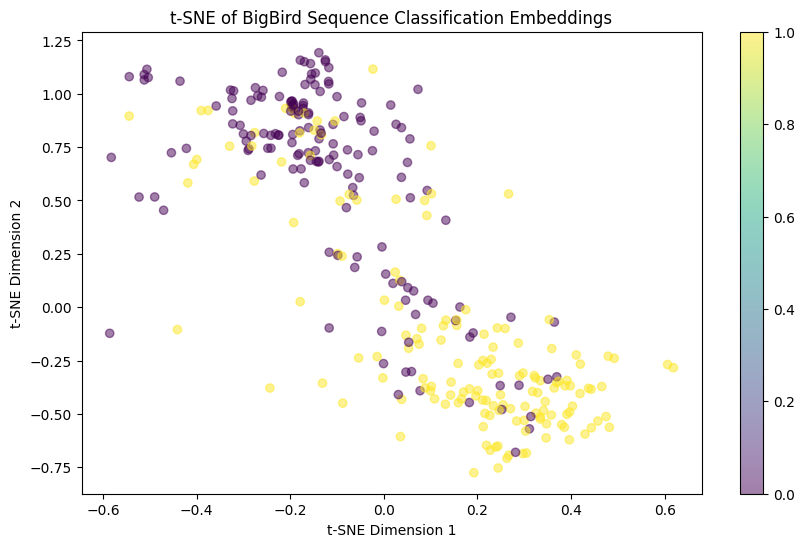

In [ ]:
plot_tsne(train_embeddings, train_labels, "t-SNE of BigBird Sequence Classification Embeddings")